Configuration

In [1]:
#Input path
folder = "/home/clowis/cernbox/cern_data/CTR bench analysis/2x2x20bgo/"
#folder = "/home/clowis/cernbox/CTR-bench/BGO_Epic_3675vs3676_3x3x3_Teflon_Melt1582_S14160-6936_1vs2_TB-amp_15122022/"
#measurement we want to look ad (last number) e.g. "00021"
measurement = "00001"
#names of different channels
c_name        = ["F1",                      #1
                 "F2",                      #2
                 "F3",                      #3
                 "F4",                      #4
                 "F5",                      #5
                 "F6",                      #6
                 "F10",                     #7
                 "F11",                     #8
                 "F12"]                     #9
#names of the channels (hard coded, dont change!)
new_name      = ["max_energy_left_mV",      #1
                 "max_energy_right_mV",     #2
                 "delta_t_ps",              #3
                 "RMS_left_mV",             #4
                 "int_energy_left_nVs",     #5
                 "int_energy_right_nVs",    #6
                 "RMS_right_mV",            #7
                 "rise_t_left_ps",          #8
                 "rise_t_right_ps"]         #9
corr_factor   = [-1e3,                      #1
                 -1e3,                      #2
                 1e12,                      #3
                 1e3,                       #4
                 -1e9,                      #5
                 -1e9,                      #6
                 1e3,                       #7
                 1e12,                      #8
                 1e12]                      #9
show_plots    = True
#no. of plots next to each other
plots         = 3
#photopeak selection
#based of Energy or area around peak? "energy" "area"
photo         = "energy"
up            = 665/511
down          = 440/511
en_cut_up     = 0.2
en_cut_low    = 0.2
#band-pass rise time, rms, delta t
rt_low        = 0.00000001
rt_up         = 1000
rms_low       = 0.00000001
rms_up        = 5
dt_low        = -1000
dt_up         = 1000
#save results for output as dictionary
#Append in code with
#results["new_entry"] = new_entry
results = {"folder": folder, "measurement": measurement}

Import

In [2]:
import numpy as np
import glob
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from matplotlib.textpath import TextPath
from matplotlib.colors import Normalize
import scipy.stats
import pandas as pd
import glob
import math
from scipy.optimize import curve_fit
%matplotlib widget
plt.close()

Functions

In [3]:
def Energy_fit(x, a, b, c, d, e, f):
    return a / np.sqrt(1 + np.power((x / np.abs(b)), c)) + d * np.exp(-(x - e)**2 / (2 * f**2))

def Gauss(x, d, e, f):
    return d * np.exp(-(x - e)**2 / (2 * f**2))

def Compton(x, a, b, c):
    return a / np.sqrt(1 + np.power((x / np.abs(b)), c))

def doubleGauss(x, a, b, c, d, f, g):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d * np.exp(-(x - b)**2 / (2 * f**2)) + g

def doubleGauss2(x, a, b, c, d, f):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d * np.exp(-(x - b)**2 / (2 * f**2))

transform data in dataframe

In [4]:
data = pd.DataFrame()
files = glob.glob(folder+"*"+measurement+".txt")
for i in range(len(files)):
    temp = []
    with open(files[i]) as f:
        temp = f.readlines()
        temp = temp[5:]
        name = os.path.basename(files[i])
        if name[2].isnumeric() == True:
            name = name[:3]
        elif name[2].isnumeric() == False:
            name = name[:2]
        for j in range(len(temp)):
            temp[j] = temp[j][temp[j].find(";")+1:-1]
            data[name] = temp
            

transform DataFrame str to fload and remove entries with corrupted information

In [5]:
rows = []
for col in range(len(data.columns)):
    for row in range(len(data)):
        if data.iloc[row,col] == "-1.#IND":
            rows.append(row)

data = data.drop(rows)
data = data.reset_index(drop=True)

for col in range(len(data.columns)):
    for row in range(len(data)):
        data.iloc[row,col] = float(data.iloc[row,col])

rename columns and add units

In [6]:
for i in range(len(c_name)):
    data = data.rename(columns={c_name[i]: new_name[i]})
    data.loc[:,new_name[i]] = data.loc[:,new_name[i]] * corr_factor[i]

data = data.reindex(sorted(data.columns), axis=1)
data_uncut = data
new_name = sorted(new_name)

Histogramms 

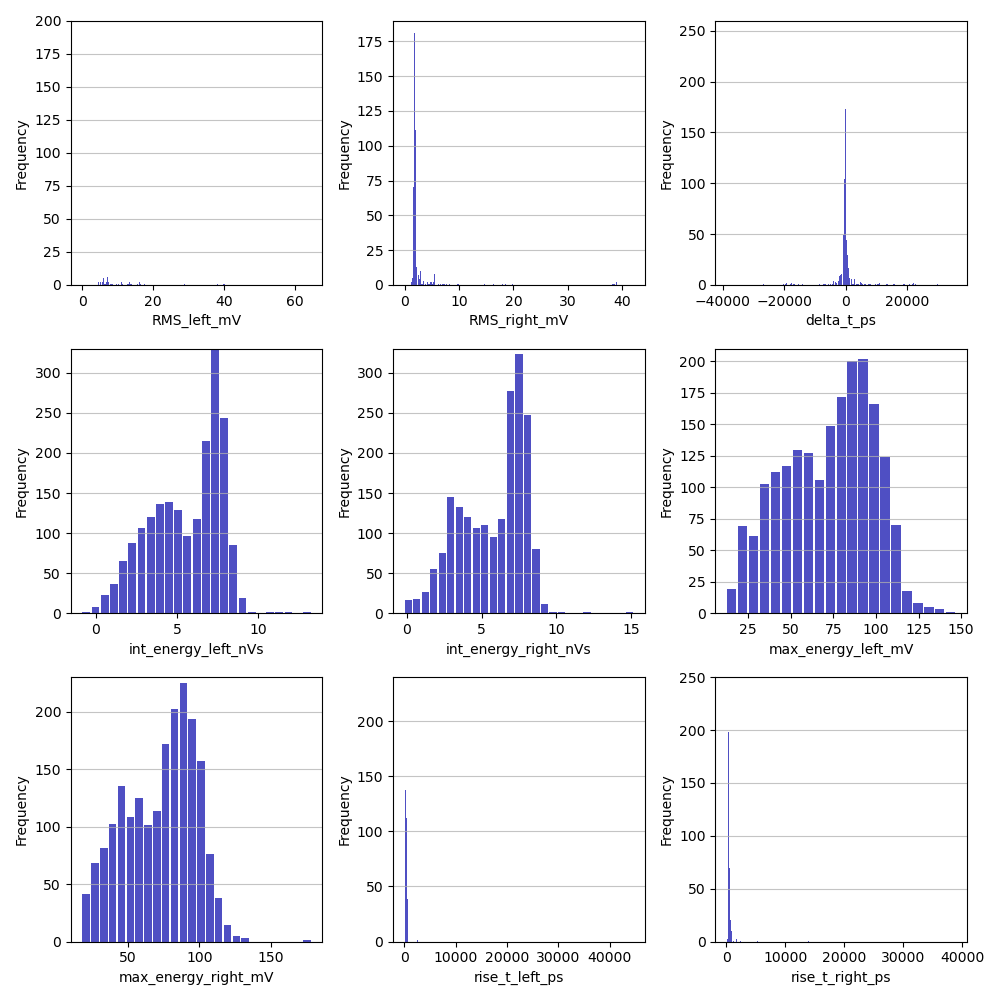

In [7]:
plt.close("Hist_uncut")

hist_data_uncut = pd.DataFrame()
if show_plots == False:
    print("Plots are off")
elif show_plots == True:
    f, ax = plt.subplots(nrows=int(np.ceil(len(c_name)/plots)),ncols=plots, figsize=(10,10), num='Hist_uncut')
    for i in range(len(new_name)):

        x = new_name[i]

        q1 = pd.Series(data_uncut[x]).quantile(0.25)
        q3 = pd.Series(data_uncut[x]).quantile(0.75)
        iqr = q3 - q1
        bin_width = (2 * iqr) / (len(pd.Series(data_uncut[x])) ** (1 / 3))
        bin_count = int(np.ceil((pd.Series(data_uncut[x]).max() - pd.Series(data_uncut[x]).min()) / bin_width))

        x = new_name[i]

        ax2 = int((i+1) - plots*int((i)/plots))-1
        ax1 = int(np.ceil((i+1)/plots))-1

        n, bins, patches = ax[ax1,ax2].hist(list(data_uncut[x]), bins=bin_count, color='#0504aa',alpha=0.7, rwidth=0.85)
        ax[ax1,ax2].grid(axis='y', alpha=0.75)
        ax[ax1,ax2].set_xlabel(x)
        ax[ax1,ax2].set_ylabel('Frequency')
        maxfreq = n.max()
        # Set a clean upper y-axis limit.
        ax[ax1,ax2].set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

        additional = pd.DataFrame({str("n_" + x): n})
        hist_data_uncut = pd.concat([hist_data_uncut, additional], axis=1) 

        patches_list = []
        for j in patches:
            patches_list.append(j.get_x()+j.get_width()/2)
        additional = pd.DataFrame({str("x_" + x): patches_list})
        hist_data_uncut = pd.concat([hist_data_uncut, additional], axis=1)

    plt.tight_layout()
    plt.show("Hist_uncut")

Scatter plots uncut

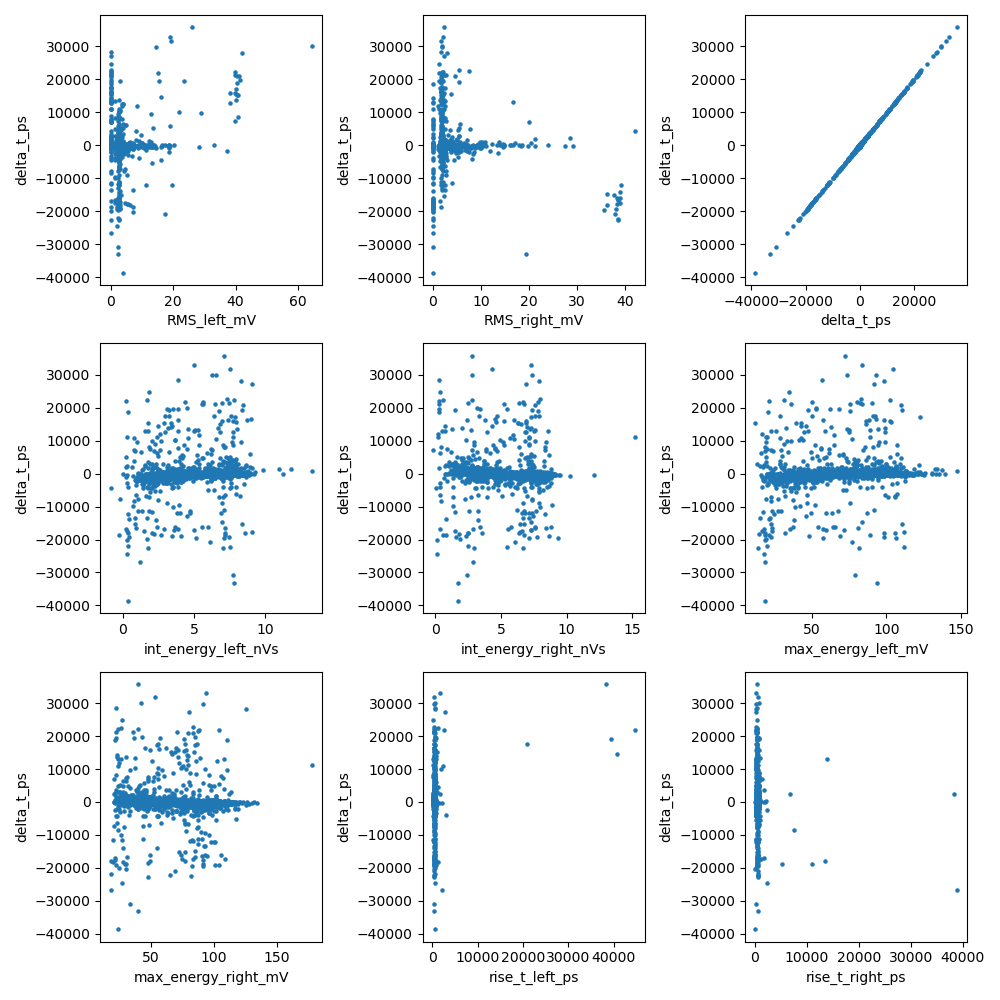

In [8]:
plt.close("Scatter_uncut")

#scatter_data = pd.DataFrame()
if show_plots == False:
    print("Plots are off")
elif show_plots == True:
    f, ax = plt.subplots(nrows=int(np.ceil(len(c_name)/plots)),ncols=plots, figsize=(10,10), num='Scatter_uncut')
    for i in range(len(new_name)):

        x = new_name[i]
        q1 = pd.Series(data[x]).quantile(0.25)
        q3 = pd.Series(data[x]).quantile(0.75)
        iqr = q3 - q1
        bin_width = (2 * iqr) / (len(pd.Series(data[x])) ** (1 / 3))
        bin_count = int(np.ceil((pd.Series(data[x]).max() - pd.Series(data[x]).min()) / bin_width))

        x = new_name[i]

        ax2 = int((i+1) - plots*int((i)/plots))-1
        ax1 = int(np.ceil((i+1)/plots))-1

        ax[ax1,ax2].scatter(list(data[x]), list(data.delta_t_ps), marker="o", s=5)
        ax[ax1,ax2].set_xlabel(x)
        ax[ax1,ax2].set_ylabel('delta_t_ps')

    plt.tight_layout()
    plt.show("Scatter_uncut")


Cut data for RISE TIME, RMS, DELTA T

In [9]:
rows = []
for row in range(len(data)):
    #rt
    if data.rise_t_right_ps[row] < rt_low or data.rise_t_right_ps[row] > rt_up or data.rise_t_left_ps[row] < rt_low or data.rise_t_left_ps[row] > rt_up:
        rows.append(row)
    #rms
    if data.RMS_right_mV[row] < rms_low or data.RMS_right_mV[row] > rms_up or data.RMS_left_mV[row] < rms_low or data.RMS_left_mV[row] > rms_up:
        rows.append(row)
    #dt
    if data.delta_t_ps[row] < np.mean(data.delta_t_ps)+dt_low or np.mean(data.delta_t_ps)+data.delta_t_ps[row] > dt_up:
        rows.append(row)
    
data = data.drop(rows)
data = data.reset_index(drop=True)

Energy fit

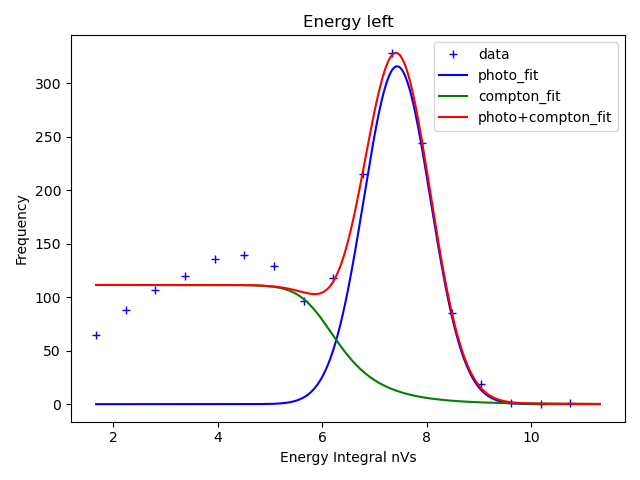

In [10]:
#Energy fit left
max_n = np.max(hist_data_uncut.n_int_energy_left_nVs)
max_ind = int(hist_data_uncut[hist_data_uncut.n_int_energy_left_nVs==max_n].index.values)
p_upper_ind = int(max_ind*1.5)
p_lower_ind = int(max_ind*.85)
c_lower_ind = int(p_lower_ind * 0.45)
c_upper_ind = int(p_lower_ind * 1)

#quess values
x = np.array(hist_data_uncut.x_int_energy_left_nVs[p_lower_ind:p_upper_ind])
y = np.array(hist_data_uncut.n_int_energy_left_nVs[p_lower_ind:p_upper_ind])
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
d = np.max(y)
e = sum(x * y) / sum(y)
f = np.sqrt(sum(y * (x - mean)**2) / sum(y))
x = np.array(hist_data_uncut.x_int_energy_left_nVs[c_lower_ind:c_upper_ind])
y = np.array(hist_data_uncut.n_int_energy_left_nVs[c_lower_ind:c_upper_ind])
a = np.max(y)
b = hist_data_uncut.x_int_energy_left_nVs[int(c_upper_ind)]
c = 1
x = np.array(hist_data_uncut.x_int_energy_left_nVs[c_lower_ind:p_upper_ind])
y = np.array(hist_data_uncut.n_int_energy_left_nVs[c_lower_ind:p_upper_ind])
x_fit_left = np.arange(hist_data_uncut.x_int_energy_left_nVs[c_lower_ind],hist_data_uncut.x_int_energy_left_nVs[p_upper_ind],0.005)

popt_left,pcov = curve_fit(Energy_fit, x, y, p0=[a,b,c,d,e,f])
y_fit_left = Gauss(x_fit_left, popt_left[3], popt_left[4], popt_left[5])

if show_plots == True:
    plt.close("Energy fit left")
    plt.figure("Energy fit left")
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x_fit_left, Gauss(x_fit_left, popt_left[3], popt_left[4], popt_left[5]), 'b-', label='photo_fit')
    plt.plot(x_fit_left, Compton(x_fit_left, popt_left[0], popt_left[1], popt_left[2]), 'g-', label='compton_fit')
    plt.plot(x_fit_left, Energy_fit(x_fit_left, *popt_left), 'r-', label='photo+compton_fit')
    plt.legend()
    plt.title('Energy left')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("Plots are off")

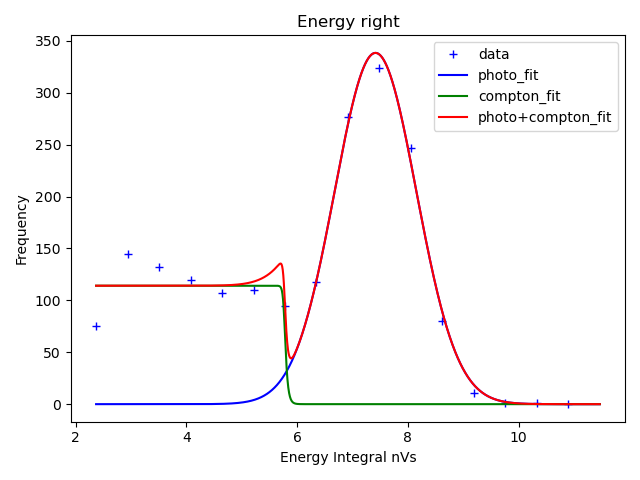

In [11]:
#Energy fit right
max_n = np.max(hist_data_uncut.n_int_energy_right_nVs)
max_ind = int(hist_data_uncut[hist_data_uncut.n_int_energy_right_nVs==max_n].index.values)
p_upper_ind = int(max_ind*up*1.2)
p_lower_ind = int(max_ind*down)
c_lower_ind = int(p_lower_ind * 0.45)
c_upper_ind = int(p_lower_ind * 1)

#quess values
x = np.array(hist_data_uncut.x_int_energy_right_nVs[p_lower_ind:p_upper_ind])
y = np.array(hist_data_uncut.n_int_energy_right_nVs[p_lower_ind:p_upper_ind])
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
d = np.max(y)
e = sum(x * y) / sum(y)
f = np.sqrt(sum(y * (x - mean)**2) / sum(y))
x = np.array(hist_data_uncut.x_int_energy_right_nVs[c_lower_ind:c_upper_ind])
y = np.array(hist_data_uncut.n_int_energy_right_nVs[c_lower_ind:c_upper_ind])
a = np.max(y)
b = hist_data_uncut.x_int_energy_right_nVs[int(c_upper_ind)]
c = 1
x = np.array(hist_data_uncut.x_int_energy_right_nVs[c_lower_ind:p_upper_ind])
y = np.array(hist_data_uncut.n_int_energy_right_nVs[c_lower_ind:p_upper_ind])
x_fit_right = np.arange(hist_data_uncut.x_int_energy_right_nVs[c_lower_ind],hist_data_uncut.x_int_energy_right_nVs[p_upper_ind],0.005)

popt_right,pcov = curve_fit(Energy_fit, x, y, p0=[a,b,c,d,e,f])
y_fit_right = Gauss(x_fit_right, popt_right[3], popt_right[4], popt_right[5])

if show_plots == True:
    plt.close("Energy fit right")
    plt.figure("Energy fit right")
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x_fit_right, Gauss(x_fit_right, popt_right[3], popt_right[4], popt_right[5]), 'b-', label='photo_fit')
    plt.plot(x_fit_right, Compton(x_fit_right, popt_right[0], popt_right[1], popt_right[2]), 'g-', label='compton_fit')
    plt.plot(x_fit_right, Energy_fit(x_fit_right, *popt_right), 'r-', label='photo+compton_fit')
    plt.legend()
    plt.title('Energy right')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("Plots are off")

Energy cut

In [12]:
#left
np.max(y_fit_left)
y_fit_left = list(y_fit_left)
max_y = np.max(y_fit_left)
max_index = list(y_fit_left).index(max_y)

arr = np.asarray(y_fit_left[0:max_index])
ind1 = (np.abs(arr - en_cut_low*max_y).argmin())
arr = np.asarray(y_fit_left[max_index:])
ind2 = (np.abs(arr - en_cut_up*max_y).argmin()) + max_index

ind1x = round(down*max_index) 
ind2x = round(up*max_index) 

if photo == "energy":
    x1 = x_fit_left[ind1x]
    x2 = x_fit_left[ind2x]
    plt.figure("Energy fit left")
    plt.axvline(x=x1)
    plt.axvline(x=x2)
elif photo == "area":
    x1 = x_fit_left[ind1]
    x2 = x_fit_left[ind2]
    plt.figure("Energy fit left")
    plt.axvline(x=x1)
    plt.axvline(x=x2)

rows = []
for row in range(len(data)):
    if data.int_energy_left_nVs[row] < x1 or data.int_energy_left_nVs[row] > x2:
        rows.append(row)
    
data = data.drop(rows)
data = data.reset_index(drop=True)

#right
np.max(y_fit_right)
y_fit_right = list(y_fit_right)
max_y = np.max(y_fit_right)
max_index = list(y_fit_right).index(max_y)

arr = np.asarray(y_fit_right[0:max_index])
ind1 = (np.abs(arr - en_cut_low*max_y).argmin())
arr = np.asarray(y_fit_right[max_index:])
ind2 = (np.abs(arr - en_cut_up*max_y).argmin()) + max_index

ind1x = round(down*max_index) 
ind2x = round(up*max_index) 

if photo == "energy":
    x1 = x_fit_right[ind1x]
    x2 = x_fit_right[ind2x]
    plt.figure("Energy fit right")
    plt.axvline(x=x1)
    plt.axvline(x=x2)
elif photo == "area":
    x1 = x_fit_right[ind1]
    x2 = x_fit_right[ind2]
    plt.figure("Energy fit right")
    plt.axvline(x=x1)
    plt.axvline(x=x2)

rows = []
for row in range(len(data)):
    if data.int_energy_right_nVs[row] < x1 or data.int_energy_right_nVs[row] > x2:
        rows.append(row)
    
data = data.drop(rows)
data = data.reset_index(drop=True)

Histogramm with cut data

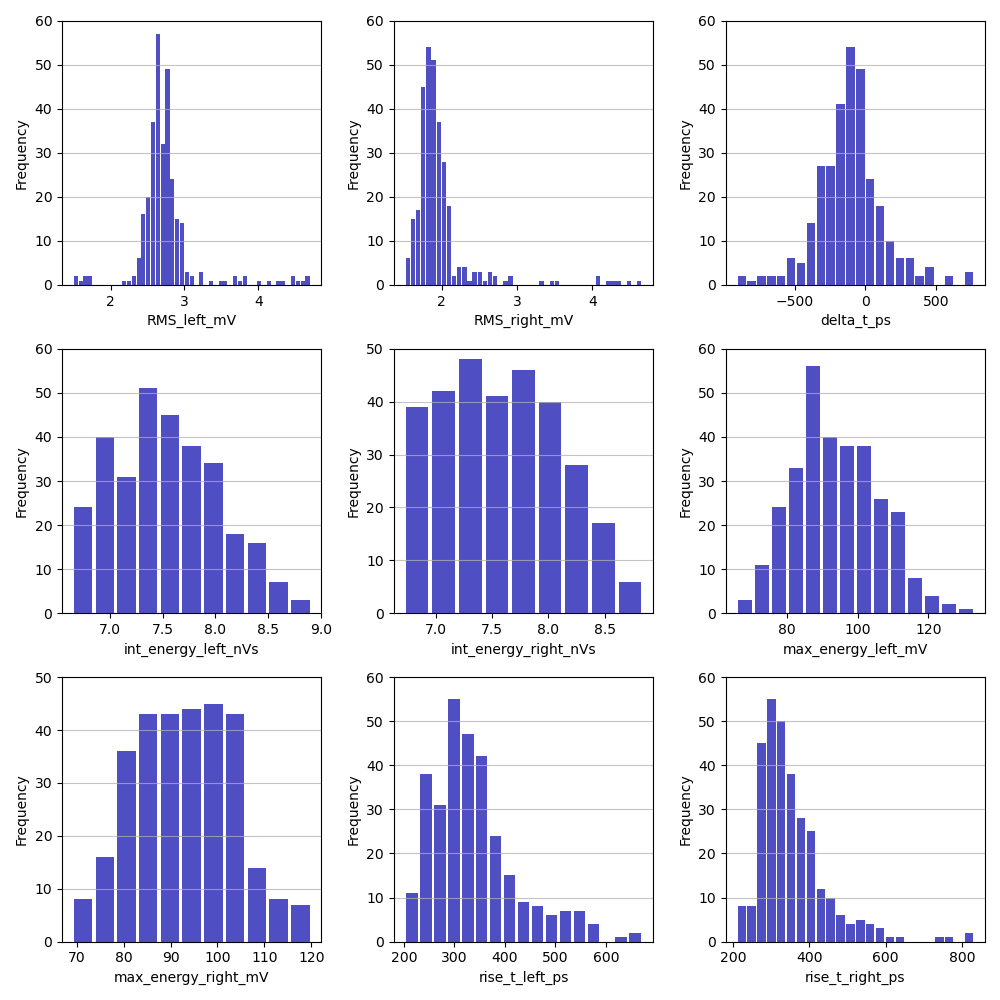

In [13]:
plt.close("Hist_cut")

hist_data = pd.DataFrame()
if show_plots == False:
    print("Plots are off")
elif show_plots == True:
    f, ax = plt.subplots(nrows=int(np.ceil(len(c_name)/plots)),ncols=plots, figsize=(10,10), num='Hist_cut')
    for i in range(len(new_name)):

        x = new_name[i]
        q1 = pd.Series(data[x]).quantile(0.25)
        q3 = pd.Series(data[x]).quantile(0.75)
        iqr = q3 - q1
        bin_width = (2 * iqr) / (len(pd.Series(data[x])) ** (1 / 3))
        bin_count = int(np.ceil((pd.Series(data[x]).max() - pd.Series(data[x]).min()) / bin_width))

        x = new_name[i]

        ax2 = int((i+1) - plots*int((i)/plots))-1
        ax1 = int(np.ceil((i+1)/plots))-1

        n, bins, patches = ax[ax1,ax2].hist(list(data[x]), bins=bin_count, color='#0504aa',alpha=0.7, rwidth=0.85)
        ax[ax1,ax2].grid(axis='y', alpha=0.75)
        ax[ax1,ax2].set_xlabel(x)
        ax[ax1,ax2].set_ylabel('Frequency')
        maxfreq = n.max()
        # Set a clean upper y-axis limit.
        ax[ax1,ax2].set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

        additional = pd.DataFrame({str("n_" + x): n})
        hist_data = pd.concat([hist_data, additional], axis=1) 

        patches_list = []
        for j in patches:
            patches_list.append(j.get_x()+j.get_width()/2)
        additional = pd.DataFrame({str("x_" + x): patches_list})
        hist_data = pd.concat([hist_data, additional], axis=1)
        
    plt.tight_layout()
    plt.show("Hist_cut")


delta_t peak fit

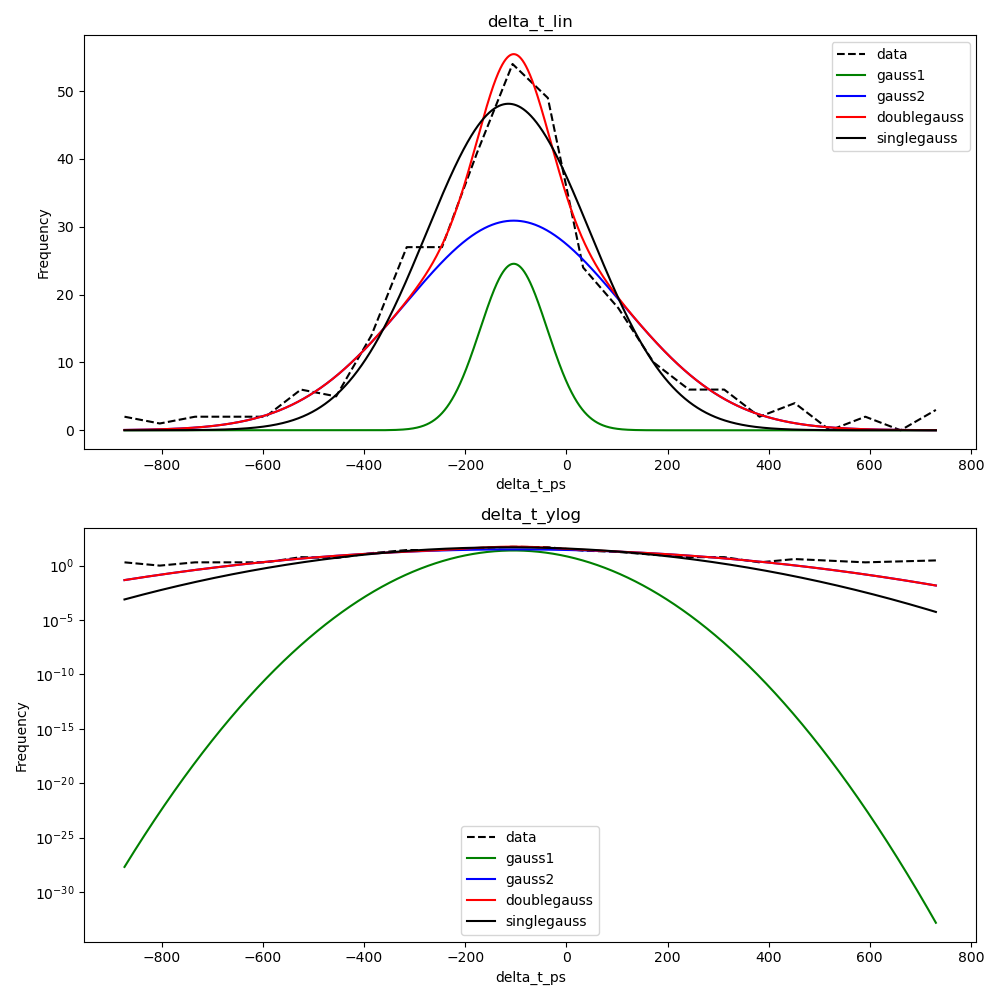

In [14]:
#quess values
plt.close("delta_t")

x = np.array([x for x in list(hist_data.x_delta_t_ps) if str(x) != 'nan'])
y = np.array([x for x in list(hist_data.n_delta_t_ps) if str(x) != 'nan'])
cut = 0.25
indices1 = list(range(len(x)-int(cut*len(x)), len(x)))
indices2 = list(range(0, int(cut*len(x))))
indices = indices1 + indices2
x = np.array([i for j, i in enumerate(x) if j not in indices])
y = np.array([i for j, i in enumerate(y) if j not in indices])
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
a = np.max(y)
b = sum(x * y) / sum(y)
c = np.sqrt(sum(y * (x - mean)**2) / sum(y))

indices1 = list(range(len(x)-int(cut*len(x)), len(x)))
indices2 = list(range(0, int(cut*len(x))))
indices = indices1 + indices2
x = np.array([i for j, i in enumerate(x) if j in indices])
y = np.array([i for j, i in enumerate(y) if j in indices])
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
d = np.max(y)
f = np.sqrt(sum(y * (x - mean)**2) / sum(y))
g = 1

x = np.array([x for x in list(hist_data.x_delta_t_ps) if str(x) != 'nan'])
y = np.array([x for x in list(hist_data.n_delta_t_ps) if str(x) != 'nan'])
x_fit_deltat = np.arange(x[0],x[-1],0.005)

#remove 0 in data for the fit
x_for_fit = []
y_for_fit = []
for i in range(len(y)):
    if y[i] != 0:
        x_for_fit.append(x[i])
        y_for_fit.append(y[i])

x_for_fit = np.array(x_for_fit)
y_for_fit = np.array(y_for_fit)
        
    
popt_deltat,pcov = curve_fit(doubleGauss2, x_for_fit, y_for_fit, p0=[a,b,c,d,f])
y_fit_deltat = doubleGauss2(x_fit_deltat, *popt_deltat)
popt_deltat_1g,pcov_1g = curve_fit(Gauss, x_for_fit, y_for_fit, p0=[a,b,c])

if show_plots == True:
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10), num="delta_t")
    
    ax1.plot(x, y, 'k--', label='data')
    ax1.plot(x_fit_deltat, Gauss(x_fit_deltat, popt_deltat[0], popt_deltat[1], popt_deltat[2]), 'g-', label='gauss1')
    ax1.plot(x_fit_deltat, Gauss(x_fit_deltat, popt_deltat[3], popt_deltat[1], popt_deltat[4]), 'b-', label='gauss2')
    ax1.plot(x_fit_deltat, doubleGauss2(x_fit_deltat, *popt_deltat), 'r-', label='doublegauss')
    ax1.plot(x_fit_deltat, Gauss(x_fit_deltat, *popt_deltat_1g), 'k-', label='singlegauss')
    ax1.legend()
    ax1.set_title('delta_t_lin')
    ax1.set_xlabel('delta_t_ps')
    ax1.set_ylabel('Frequency')
    
    ax2.plot(x_for_fit, y_for_fit, 'k--', label='data')
    ax2.plot(x_fit_deltat, Gauss(x_fit_deltat, popt_deltat[0], popt_deltat[1], popt_deltat[2]), 'g-', label='gauss1')
    ax2.plot(x_fit_deltat, Gauss(x_fit_deltat, popt_deltat[3], popt_deltat[1], popt_deltat[4]), 'b-', label='gauss2')
    ax2.plot(x_fit_deltat, doubleGauss2(x_fit_deltat, *popt_deltat), 'r-', label='doublegauss')
    ax2.plot(x_fit_deltat, Gauss(x_fit_deltat, *popt_deltat_1g), 'k-', label='singlegauss')
    ax2.legend()
    ax2.set_title('delta_t_ylog')
    ax2.set_xlabel('delta_t_ps')
    ax2.set_ylabel('Frequency')
    ax2.set_yscale("log")
    
    plt.tight_layout()
    plt.show("delta_t")
else:
    print("Plots are off")

Scatter plots

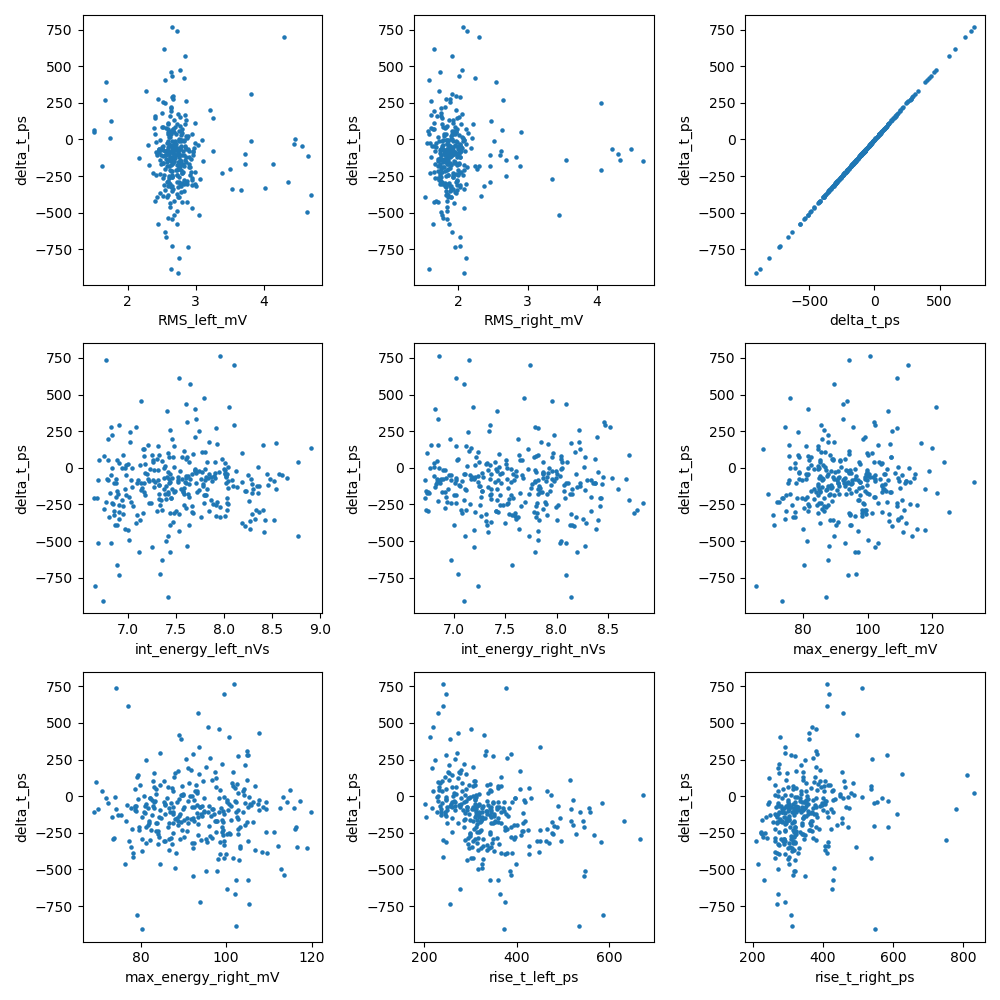

In [15]:
plt.close("Scatter_cut")

#scatter_data = pd.DataFrame()
if show_plots == False:
    print("Plots are off")
elif show_plots == True:
    f, ax = plt.subplots(nrows=int(np.ceil(len(c_name)/plots)),ncols=plots, figsize=(10,10), num='Scatter_cut')
    for i in range(len(new_name)):

        x = new_name[i]
        q1 = pd.Series(data[x]).quantile(0.25)
        q3 = pd.Series(data[x]).quantile(0.75)
        iqr = q3 - q1
        bin_width = (2 * iqr) / (len(pd.Series(data[x])) ** (1 / 3))
        bin_count = int(np.ceil((pd.Series(data[x]).max() - pd.Series(data[x]).min()) / bin_width))

        x = new_name[i]

        ax2 = int((i+1) - plots*int((i)/plots))-1
        ax1 = int(np.ceil((i+1)/plots))-1

        ax[ax1,ax2].scatter(list(data[x]), list(data.delta_t_ps), marker="o", s=5)
        ax[ax1,ax2].set_xlabel(x)
        ax[ax1,ax2].set_ylabel('delta_t_ps')

    plt.tight_layout()
    plt.show("Scatter_cut")
